In [ ]:
!pip3 install 'git+https://github.com/alexlatchford/pipelines@alexla/AIP-1676#egg=kfp&subdirectory=sdk/python'

In [5]:
# Solved!
import yaml
import kfp
from kfp import compiler, dsl
from kfp.dsl import ContainerOp, python_component, RUN_ID_PLACEHOLDER
from kfp.components import func_to_container_op, func_to_component_text, load_component_from_text


def pipeline_transformer(op: ContainerOp):
    op.execution_options.caching_strategy.max_cache_staleness = "P0D"
    op.container.set_cpu_request("100m")
    op.container.set_cpu_limit("150m")
    
def named_op(name: str, func: callable) -> ContainerOp:
    text = yaml.load(func_to_component_text(func), yaml.SafeLoader)
    text["name"] = name
    return load_component_from_text(yaml.dump(text))

In [10]:
def foreach_step(p) -> list:
    print(p)
    return [f"{p}_{i}".strip("_") for i in range(1, 3)]

@func_to_container_op
def inner_step(p) -> list:
    print(p)
    return None

def join_results(results, split="") -> list:
    print(results)
    print("split", split)
    return None    

# ParallelFor with join
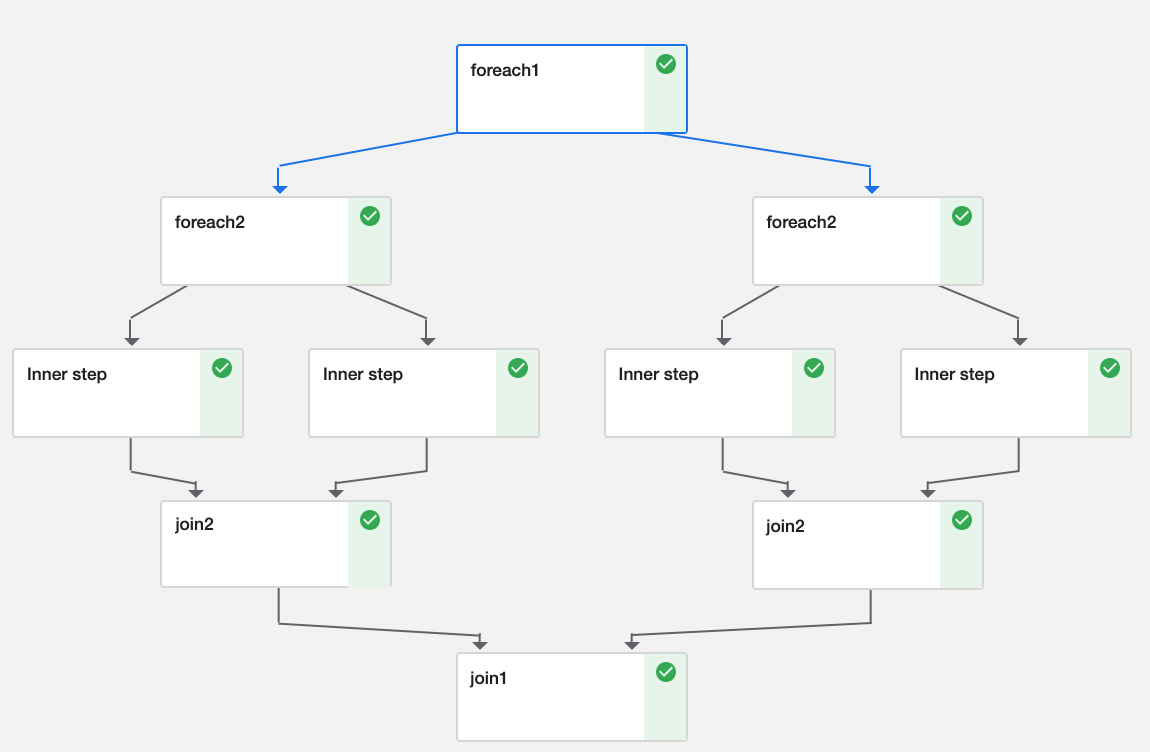

Split Outputs for foreach1: [1, 2]

Split Outputs for foreach2: ["1_1",  "1_2"] and ["2_1",  "2_2"]

In [11]:
@kfp.dsl.pipeline(name="test", description="test")
def map_reduce_pipeline():  
    op1_foreach = named_op("foreach1", foreach_step)("")
    with kfp.dsl.ParallelFor(op1_foreach.output) as split_1:  # ** The split_1 is how inner MF steps are named: "<step_name>:<split_1>"
        
        # foreach
        op2_foreach = named_op("foreach2", foreach_step)(split_1)
        with kfp.dsl.ParallelFor(op2_foreach.output) as split_2:
            op3_inner = inner_step(split_2)
        # ** Join on op2_foreach with split_1 naming: <step_name>:<split_1>
        op_join2 = named_op("join2", join_results)("op2_foreach join", split_1).after(op3_inner)
        
    # ** Join op1_foreach, but we are not inside a foreach, so no split
    named_op("join1", join_results)("op1_foreach join").after(op_join2)
    
    dsl.get_pipeline_conf().add_op_transformer(pipeline_transformer)

kfp.Client(userid="talebz@zillowgroup.com").create_run_from_pipeline_func(
    map_reduce_pipeline,
    arguments={},
    run_name="map_reduce_pipeline",
    experiment_name="kf-1.0-test-experiment",
    namespace="aip-example"
)

RunPipelineResult(run_id=d81d5134-1812-4778-86f3-d44926eee81c)

# Nested ParallelFor with join
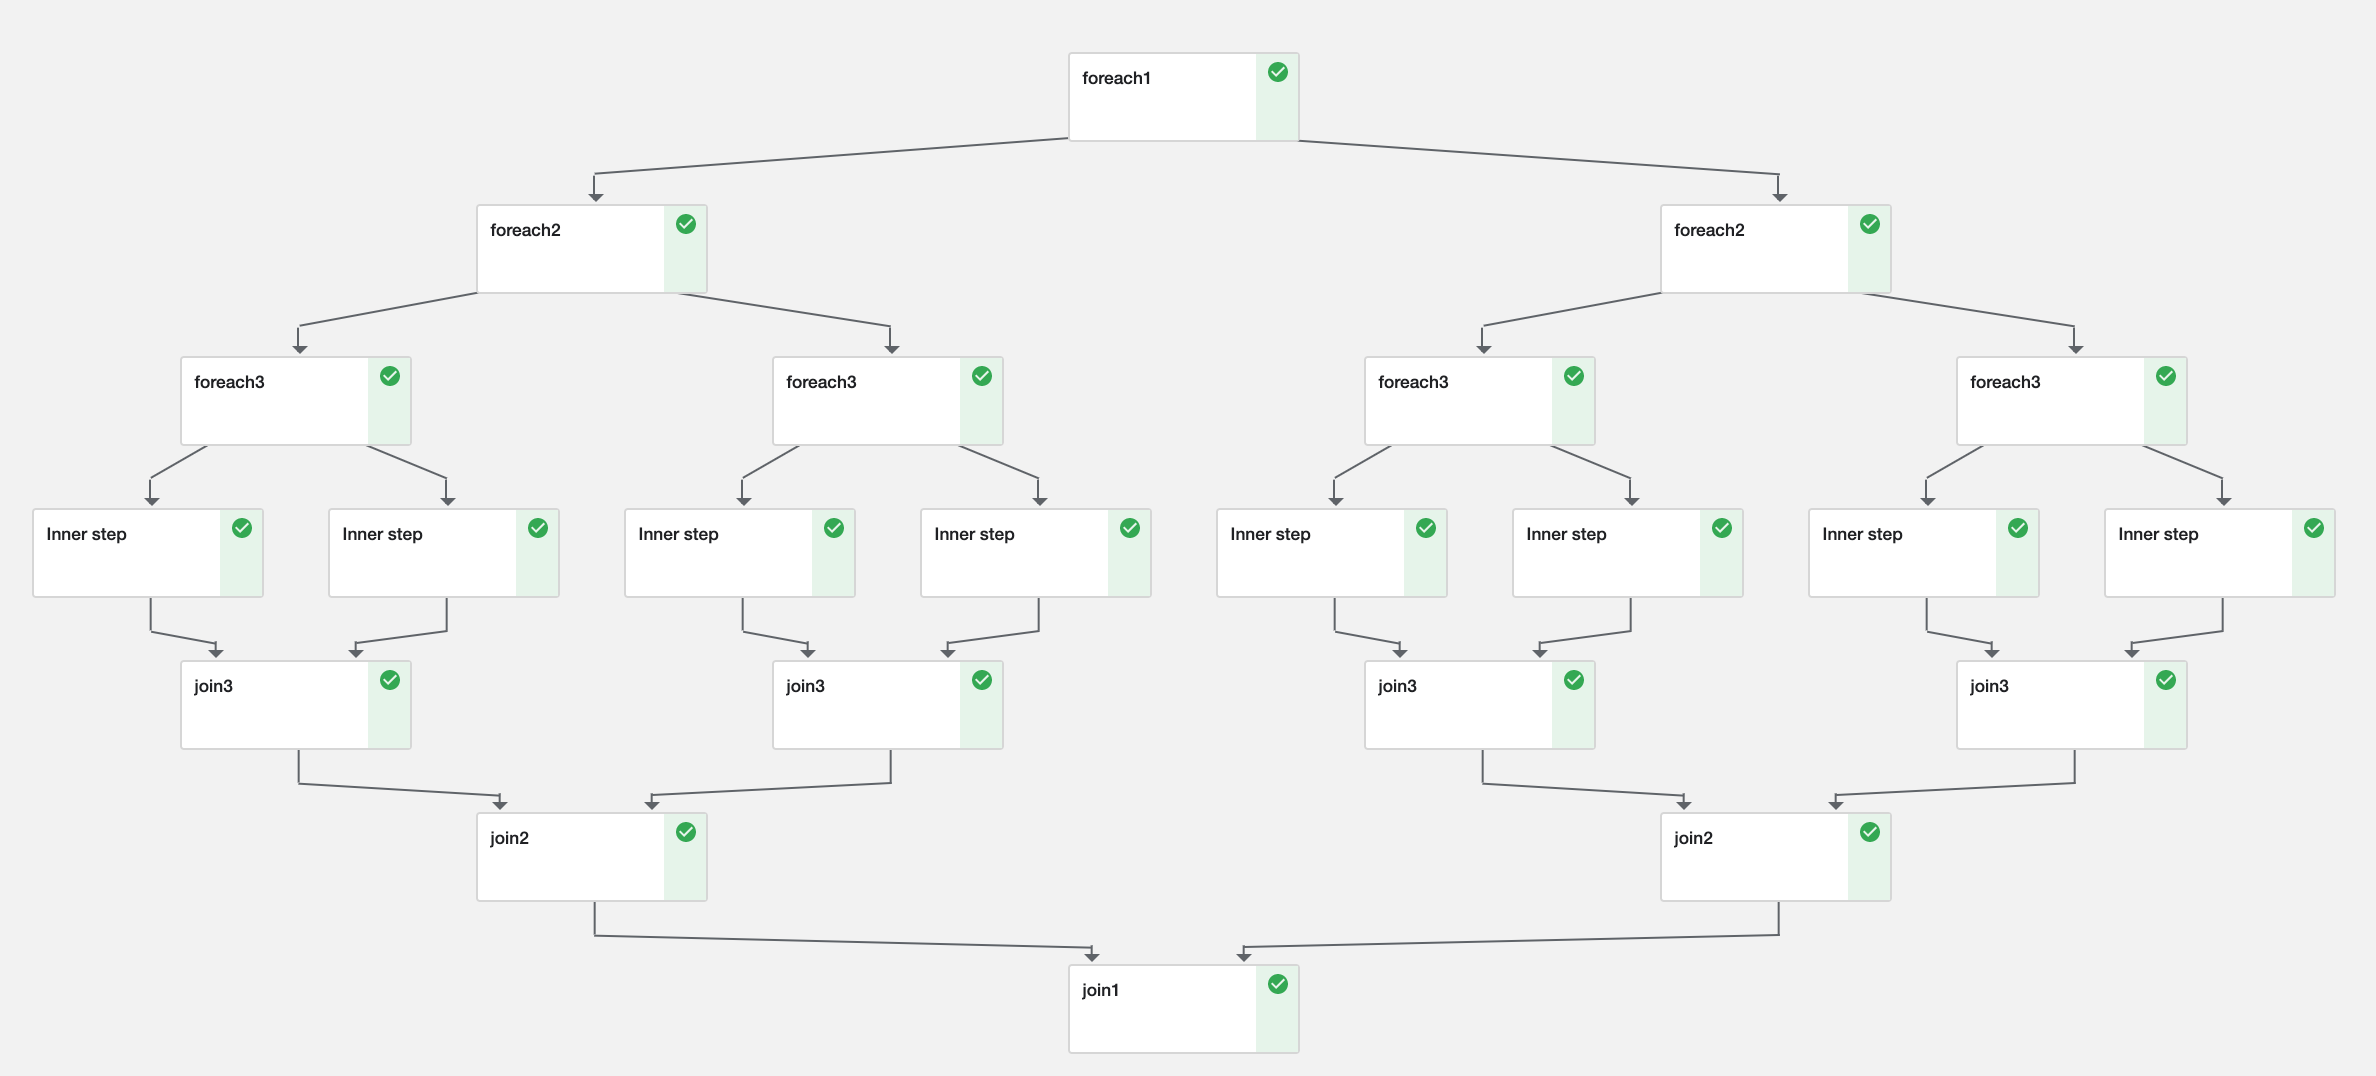

In [9]:
# 3 nested loops

@kfp.dsl.pipeline(name="test", description="test")
def map_reduce_pipeline():  
    op1_foreach = named_op("foreach1", foreach_step)("")
    with kfp.dsl.ParallelFor(op1_foreach.output) as split_1:  # ** The split_1 is how inner MF steps are named: "<step_name>:<split_1>"
        
        # foreach
        op2_foreach = named_op("foreach2", foreach_step)(split_1)
        with kfp.dsl.ParallelFor(op2_foreach.output) as split_2:
            # foreach
            op3_foreach = named_op("foreach3", foreach_step)(split_2)
            with kfp.dsl.ParallelFor(op3_foreach.output) as split_3:
                op3_inner = inner_step(split_3)            
                
            # ** Join on op2_foreach with split_1
            op_join3 = named_op("join3", join_results)("op3_foreach join", split_2).after(op3_inner)
            
            
        # ** Join on op2_foreach with split_1 
        op_join2 = named_op("join2", join_results)("op2_foreach join", split_1).after(op_join3)
        
    # ** Join op1_foreach, but we are not inside a foreach, so no split
    named_op("join1", join_results)("op1_foreach join").after(op_join2)
    
    dsl.get_pipeline_conf().add_op_transformer(pipeline_transformer)

kfp.Client(userid="talebz@zillowgroup.com").create_run_from_pipeline_func(
    map_reduce_pipeline,
    arguments={},
    run_name="map_reduce_pipeline",
    experiment_name="kf-1.0-test-experiment",
    namespace="aip-example"
)

RunPipelineResult(run_id=0f5d32c4-b60f-43dc-af5a-3a1e5b942ee2)